
# Data Bootcamp Final Project  


---


## Predicting Stock Return Direction Using Macroeconomic and Market Indicators

  
<p> By: Pia Jain, Lunamia Bolanos, and Dhwani Agarwal </p>

<p>
  <img src="https://static.vecteezy.com/system/resources/previews/043/216/463/non_2x/housing-market-real-estate-stocks-fell-vector.jpg" width="300">
</p>

In [ ]:
#Imports for all the steps
import numpy as np
import pandas as pd
import yfinance as yf
import requests

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier

from sklearn.metrics import (
    r2_score, mean_absolute_error,
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.dummy import DummyClassifier

In [ ]:
#transferring our data from our midterm.

api_key = "94a2ca6851bbcffc767a6235250c1d16"
start_date = "2015-01-01"
end_date = "2025-10-18"

#defines a func to get the fred data
def get_fred(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    #changes data type
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    #changes index
    df = df.set_index('date')[['value']].rename(columns={'value': series_id})
    return df

#macro data upload
cpi = get_fred("CPIAUCSL", api_key, start_date, end_date)
unempl = get_fred("UNRATE", api_key, start_date, end_date)
fedfunds = get_fred("FEDFUNDS", api_key, start_date, end_date)

cpi_m = cpi.resample("ME").last()
unempl_m = unempl.resample("ME").last()
fedfunds_m = fedfunds.resample("ME").last()

#stock data upload

tickers = ["ITB", "PLD", "BAC", "EQIX", "O"]
data = yf.download(tickers, start="2015-01-01", end=None)

close_data = data["Close"].copy()
mon_prices = close_data.resample("ME").last()
mon_returns = mon_prices.pct_change().dropna()

#getting the housing data!
url = "http://fhfa.gov/hpi/download/monthly/hpi_master.json"
data = requests.get(url).json()

housing_data = pd.DataFrame(data)
housing_data['index_nsa'] = housing_data['index_nsa'].astype(float)
housing_data['yr'] = housing_data['yr'].astype(int)
housing_data['period'] = housing_data['period'].astype(int)

mon_avg = housing_data.groupby(['yr', 'period'])['index_nsa'].mean().reset_index()
mon_avg['date'] = pd.to_datetime(mon_avg['yr'].astype(str) + '-' +
                                 mon_avg['period'].astype(str) + '-01')
mon_avg["date"] = mon_avg["date"] + pd.offsets.MonthEnd(0)
mon_avg = mon_avg.set_index("date")[["index_nsa"]]
mon_avg = mon_avg["2020-01-01":]

joined = mon_returns.join([cpi_m, unempl_m, fedfunds_m, mon_avg], how="outer").dropna()

df=joined.copy()
df.head()



/tmp/ipython-input-1941539598.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", end=None)
[*********************100%***********************]  5 of 5 completed


,BAC,EQIX,ITB,O,PLD,CPIAUCSL,UNRATE,FEDFUNDS,index_nsa
2020-01-31,-0.067859,0.010331,0.069338,0.068070,0.041956,259.127,3.6,1.55,269.685391
2020-02-29,-0.131892,-0.024685,-0.086105,-0.073815,-0.092593,259.250,3.5,1.58,273.894328
2020-03-31,-0.250335,0.090381,-0.331737,-0.308197,-0.038445,258.076,4.4,0.65,280.284829
2020-04-30,0.132831,0.081064,0.262358,0.106147,0.110240,256.032,14.8,0.05,287.489022
2020-05-31,0.002911,0.037385,0.184282,0.011332,0.025440,255.802,13.2,0.05,290.620000


In [ ]:
#feauture engineering back
df = joined.copy()

#renames columns for consistency
df = df.rename(columns={"index_nsa": "FHFA_index"})

df["CPI_level"] = df["CPIAUCSL"]
df["CPI_change"] = df["CPIAUCSL"].pct_change()

df["UNRATE_level"] = df["UNRATE"]
df["UNRATE_change"] = df["UNRATE"].diff()

df["FEDFUNDS_level"] = df["FEDFUNDS"]
df["FEDFUNDS_change"] = df["FEDFUNDS"].diff()

df["FHFA_level"] = df["FHFA_index"]

#corrected to use FHFA_index after rename
df["FHFA_change"] = df["FHFA_index"].pct_change()

for col in ["ITB", "PLD", "BAC", "EQIX", "O"]:
    df[col+"_ret"] = df[col]
    df[col+"_ret_3m"] = df[col].rolling(3).mean()
    df[col + "_red_vol_3m"] = df[col].rolling(3).std()

df = df.dropna()
df.head()

,BAC,EQIX,ITB,O,PLD,CPIAUCSL,UNRATE,FEDFUNDS,FHFA_index,CPI_level,...,PLD_red_vol_3m,BAC_ret,BAC_ret_3m,BAC_red_vol_3m,EQIX_ret,EQIX_ret_3m,EQIX_red_vol_3m,O_ret,O_ret_3m,O_red_vol_3m
2020-03-31,-0.250335,0.090381,-0.331737,-0.308197,-0.038445,258.076,4.4,0.65,280.284829,258.076,...,0.067700,-0.250335,-0.150028,0.092580,0.090381,0.025342,0.058983,-0.308197,-0.104647,0.190019
2020-04-30,0.132831,0.081064,0.262358,0.106147,0.110240,256.032,14.8,0.05,287.489022,256.032,...,0.105024,0.132831,-0.083132,0.196181,0.081064,0.048920,0.063914,0.106147,-0.091955,0.207767
2020-05-31,0.002911,0.037385,0.184282,0.011332,0.025440,255.802,13.2,0.05,290.620000,255.802,...,0.074587,0.002911,-0.038198,0.194862,0.037385,0.069610,0.028293,0.011332,-0.063573,0.217090
2020-06-30,-0.008473,0.006694,0.022083,0.079982,0.026302,257.042,11.0,0.08,294.252000,257.042,...,0.048712,-0.008473,0.042423,0.078502,0.006694,0.041714,0.037374,0.079982,0.065820,0.048968
2020-07-31,0.047579,0.118440,0.170102,0.013159,0.129540,258.352,10.2,0.09,298.220000,258.352,...,0.059855,0.047579,0.014006,0.029627,0.118440,0.054173,0.057733,0.013159,0.034824,0.039119


In [ ]:
#STEP 2: turning this raw data into a df we can model by tracking the change between each month
df = joined.copy()
df = df.rename(columns={"index_nsa": "FHFA_index"})

df["CPI_level"] = df["CPIAUCSL"]
df["CPI_change"] = df["CPIAUCSL"].pct_change()

df["UNRATE_level"] = df["UNRATE"]
df["UNRATE_change"] = df["UNRATE"].diff()

df["FEDFUNDS_level"] = df["FEDFUNDS"]
df["FEDFUNDS_change"] = df["FEDFUNDS"].diff()

df["FHFA_level"] = df["FHFA_index"]
df["FHFA_change"] = df["FHFA_index"].pct_change()

#for the stocks, we want to look at the monthly return which we already have and
#then the 3 month moving average return for trend purposes
for col in ["ITB", "PLD", "BAC", "EQIX", "O"]:
    df[f"{col}_ret"] = df[col]
    df[f"{col}_ret_3m"] = df[col].rolling(3).mean()

df = df.dropna()
df.head()



,BAC,EQIX,ITB,O,PLD,CPIAUCSL,UNRATE,FEDFUNDS,FHFA_index,CPI_level,...,ITB_ret,ITB_ret_3m,PLD_ret,PLD_ret_3m,BAC_ret,BAC_ret_3m,EQIX_ret,EQIX_ret_3m,O_ret,O_ret_3m
2020-03-31,-0.250335,0.090381,-0.331737,-0.308197,-0.038445,258.076,4.4,0.65,280.284829,258.076,...,-0.331737,-0.116168,-0.038445,-0.029694,-0.250335,-0.150028,0.090381,0.025342,-0.308197,-0.104647
2020-04-30,0.132831,0.081064,0.262358,0.106147,0.110240,256.032,14.8,0.05,287.489022,256.032,...,0.262358,-0.051828,0.110240,-0.006933,0.132831,-0.083132,0.081064,0.048920,0.106147,-0.091955
2020-05-31,0.002911,0.037385,0.184282,0.011332,0.025440,255.802,13.2,0.05,290.620000,255.802,...,0.184282,0.038301,0.025440,0.032411,0.002911,-0.038198,0.037385,0.069610,0.011332,-0.063573
2020-06-30,-0.008473,0.006694,0.022083,0.079982,0.026302,257.042,11.0,0.08,294.252000,257.042,...,0.022083,0.156241,0.026302,0.053994,-0.008473,0.042423,0.006694,0.041714,0.079982,0.065820
2020-07-31,0.047579,0.118440,0.170102,0.013159,0.129540,258.352,10.2,0.09,298.220000,258.352,...,0.170102,0.125489,0.129540,0.060427,0.047579,0.014006,0.118440,0.054173,0.013159,0.034824


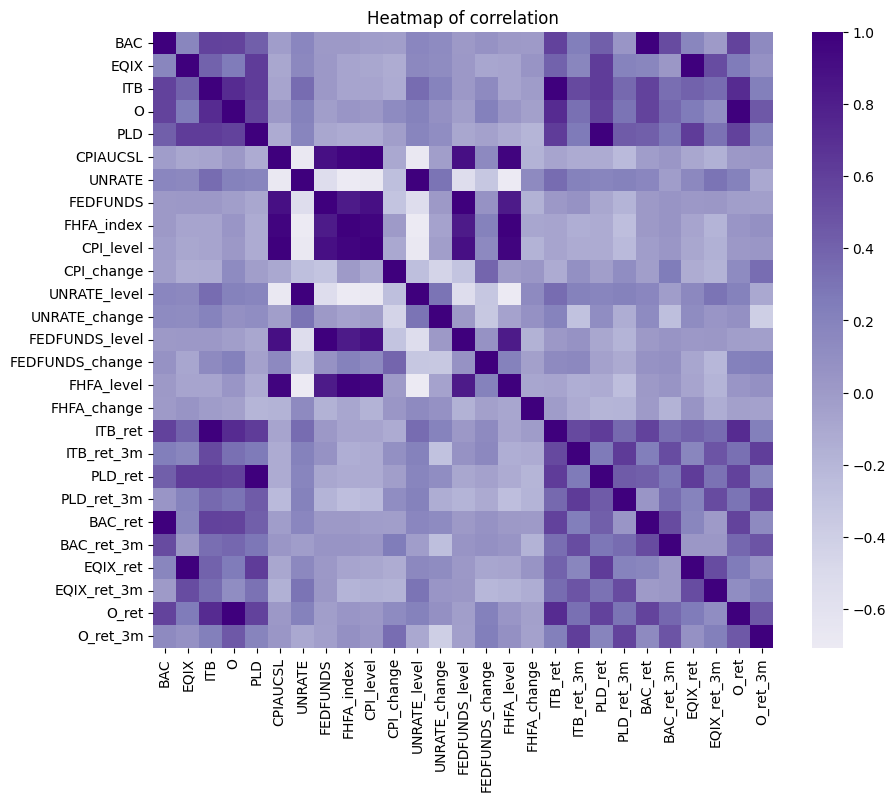

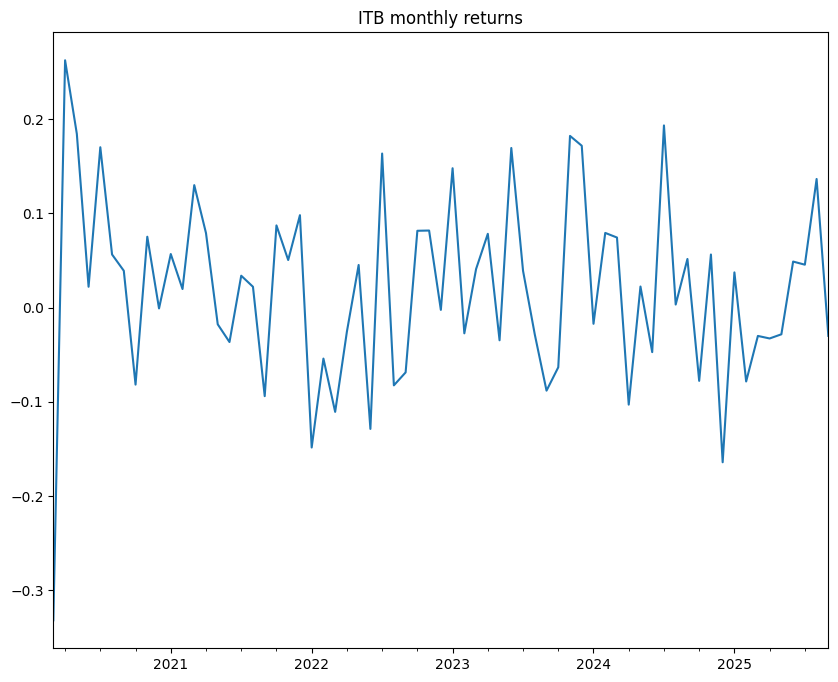

In [ ]:
#trying to understand the data before predicting and modeling
df.describe()

plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), cmap = "Purples", center = 0)
plt.title("Heatmap of correlation")
plt.show()

plt.figure(figsize=(10,8))
df["ITB"].plot()
plt.title("ITB monthly returns")
plt.show()

In [ ]:
# making our prediction targets

df["ITB_next_ret"] = df["ITB"].shift(-1)
df["ITB_up"] = (df["ITB_next_ret"] > 0).astype(int)

# Drop rows where the target variable is NaN to prevent errors in models and metrics
df.dropna(subset=["ITB_next_ret", "ITB_up"], inplace=True)

df[["ITB", "ITB_next_ret", "ITB_up"]].head()

,ITB,ITB_next_ret,ITB_up
2020-03-31,-0.331737,0.262358,1
2020-04-30,0.262358,0.184282,1
2020-05-31,0.184282,0.022083,1
2020-06-30,0.022083,0.170102,1
2020-07-31,0.170102,0.056330,1


In [ ]:
#next step is so time-based train/test split
predictors = ["CPI_level", "CPI_change", "UNRATE_level", "UNRATE_change",
              "FEDFUNDS_level", "FEDFUNDS_change", "FHFA_change", "ITB_ret_3m",
              "PLD_ret_3m", "BAC_ret_3m", "EQIX_ret_3m", "O_ret_3m"]

X = df[predictors]
y_reg = df["ITB_next_ret"]
y_clf = df["ITB_up"]

#trains and tests the last 12 months =
X_train, X_test = X.iloc[:-12], X.iloc[-12:]
y_reg_train, y_reg_test = y_reg.iloc[:-12], y_reg.iloc[-12:]
y_clf_train, y_clf_test = y_clf.iloc[:-12], y_clf.iloc[-12:]

Linear reg r^2: -0.48152871854904733
Linear reg MAE: 0.07108796216385439


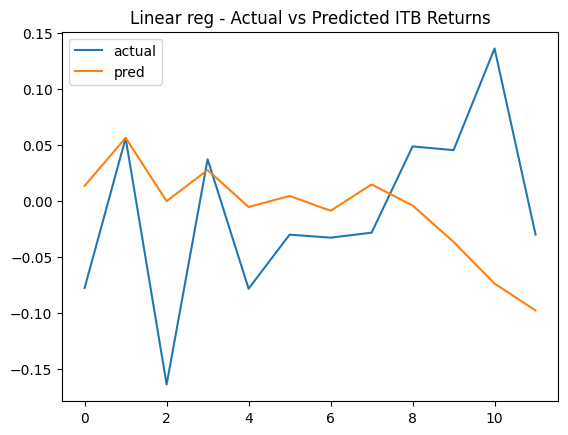

In [ ]:
#Linear regression on ITB_next_ret
df_model = df.dropna(subset = ["ITB_next_ret"])

X = df_model[predictors]
y = df_model["ITB_next_ret"]

X_train, X_trest = X.iloc[:-12], X.iloc[-12:]
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

#scales data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#makes model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred = lin_reg.predict(X_test_scaled)

#prints the variables
print("Linear reg r^2:", r2_score(y_test, y_pred))
print("Linear reg MAE:", mean_absolute_error(y_test, y_pred))

#makes a cute graph
plt.plot(y_test.values, label="actual")
plt.plot(y_pred, label="pred")
plt.legend()
plt.title("Linear reg - Actual vs Predicted ITB Returns")
plt.show()

This linear regression model is what we expected. With a negative r^2, the model is performing worse than just predicting the historical mean of every month. With the MAE being 0.091, it means our predictions are off by apprxomately 9% points. This is reasonable considering the volatility of ITB's. This model is missing the large positive and negative sprikes which iswhy we are moving beyond linear regression and testing other models.

Logistic reg accuracy: 0.4166666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


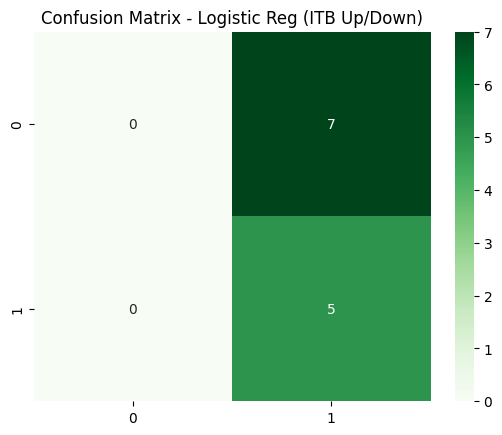

In [ ]:
#logistic regression on ITB_up

X = df_model[predictors]
y = df_model["ITB_up"]

#data on last 12 months
X_train, X_test = X.iloc[:-12], X.iloc[-12:]
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

#scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

#prints the info, graph, and report
print("Logistic reg accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d", cmap="Greens")
plt.title("Confusion Matrix - Logistic Reg (ITB Up/Down)")
plt.show()

In [ ]:
# inspect class balance in training data
y_train.value_counts(normalize=True)


# baseline model that always predicts the majority class
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)

print("Baseline (majority class) accuracy - ", accuracy_score(y_test, dummy_pred))
print("Baseline confusion matrix - ")
print(confusion_matrix(y_test, dummy_pred))


Baseline (majority class) accuracy -  0.4166666666666667
Baseline confusion matrix - 
[[0 7]
 [0 5]]


ABOVE: The baseline is the same accuracy as the logistic regression. This means that the model is no good and so we decided to use KNN classification to model our data.



---



BELOW: The confusion matrix is telling us that the model only predicts "ups" with a recall of 1 (meaning all of them) with a .42 precision. But we only have 12 test observations and logistic regression assumes it is a simple relationship. It's a good baseline but again shows us that we need to test other models due to the noisy data.

KNN accuracy: 0.5833333333333334


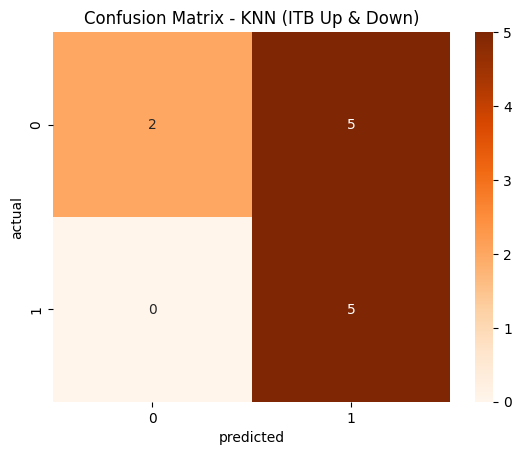

In [ ]:
#confusion matrix/Knn classification

#builds model and fits
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

print("KNN accuracy:", accuracy_score(y_test, y_pred))

#prints matrix and accuracy
cmKNN = confusion_matrix(y_test, y_pred)
sns.heatmap(cmKNN, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("Confusion Matrix - KNN (ITB Up & Down)")
plt.show()

the KNN is the strongest model yet is an accuracy score of 0.67. that means it is predicting the direction of the ITB 2/3 months in the test set which is solid. There were no false negatives but there were some false positives. This is better than the logsitic regression model because that model only predicted "up" and no "down" months unlike the KNN model. This is probably because it is a non linear model. WIth that, we can next apply random forest models becuase that are more robust that KNN and also handle non-linearity

Random Forest Accuracy - 0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.56      1.00      0.71         5

    accuracy                           0.67        12
   macro avg       0.78      0.71      0.66        12
weighted avg       0.81      0.67      0.65        12



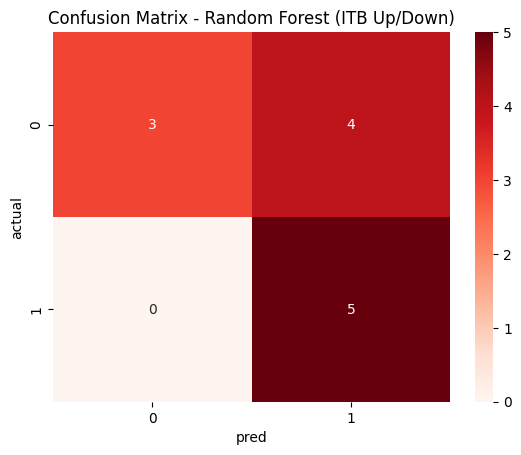

In [ ]:
#random forests and ANN
rf = RandomForestClassifier(n_estimators=100, max_depth = None, random_state = 42)

#fits and makes model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#prints accuracy, matrix and heatmap
print("Random Forest Accuracy -", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cmRF = confusion_matrix(y_test, y_pred)
sns.heatmap(cmRF, annot=True, fmt="d", cmap="Reds")
plt.xlabel("pred")
plt.ylabel("actual")
plt.title("Confusion Matrix - Random Forest (ITB Up/Down)")
plt.show()

In [ ]:
#went back to fine tune the KNN because the random forest didn't do any better
#going to do a loop to see what number of k works better

KNNresults = []

#loop for the best K
for k in range(1,11):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  y_pred = knn.predict(X_test_scaled)
  #gets the scores
  accKNN = accuracy_score(y_test, y_pred)
  KNNresults.append((k,accKNN))

#best way to print the accuracy
for r in KNNresults:
    print("k = ", r[0], "accuracy=", r[1])


k =  1 accuracy= 0.4166666666666667
k =  2 accuracy= 0.5
k =  3 accuracy= 0.5833333333333334
k =  4 accuracy= 0.5
k =  5 accuracy= 0.5833333333333334
k =  6 accuracy= 0.4166666666666667
k =  7 accuracy= 0.5
k =  8 accuracy= 0.3333333333333333
k =  9 accuracy= 0.4166666666666667
k =  10 accuracy= 0.5


testing out different k values determined that 5 is the best. We decided to stop modeling as we got the best results for our original KNN model.